Karina Chiñas Fuenes | 18/04/2023 | Universiteit Gent

In [1]:
%load_ext autoreload
%autoreload 2

This notebook is based on the document:

* _Feature Selection for Clustering_, [Manoranjan Dash and Huan Liu](https://www.public.asu.edu/~huanliu/papers/pakdd00clu.pdf), 2000.

# LOW MULTICOLLINEARITY

This notebook helps me understand if there is a structure among the variables of interest. 

In [2]:
import sys
sys.path.append('../')
import tokamakTK
from tokamakTK import get_regression

import seaborn as sns
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

pd.set_option('display.max_columns', None)
path = "../data/"
fig_path = "../../../LATEX/Latex Images/"

sstyle = 'seaborn-v0_8-poster'
plt.style.use(sstyle)
plt.rc('font',family = 'serif')

In [3]:
# Obtained from Optimization

min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.6357.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1


print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

23.45% of the data decreased alpha_R
76.55% of the data did not decrease alpha_R


In [4]:
get_regression( DB5[DB5.label.isin([1])], DB2  )[1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     5363.
Date:                Wed, 03 May 2023   Prob (F-statistic):               0.00
Time:                        14:42:11   Log-Likelihood:                 461.74
No. Observations:                2776   AIC:                            -905.5
Df Residuals:                    2767   BIC:                            -852.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2596      0.037    -60.302      0.000      -2.333      -2.186
x1             1.4219      0.022     64.538      0.000       1.379       1.465
x2             0.0199      0.020      1.006      0.315      -0.019       0.059
x3            -0.1361      0.015     -9.257      0.000      -0.165      -0.107
x4            -0.5290      0.012    -44.915      0.000      -0.552      -0.506
x5             0.6358      0.037     17.157      0.000       0.563       0.708
x6            -0.0017      0.037     -0.044      0.965      -0.075       0.071
x7            -0.5566      0.048    -11.702      0.000      -0.650      -0.463
x8             0.1296      0.026      5.050      0.000       0.079       0.180
==============================================================================
Omnibus:                       29.156   Durbin-Watson:                   0.611
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.712
Skew:                           0.026   Prob(JB):                     4.36e-11
Kurtosis:                       3.640   Cond. No.                         53.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Treatment to Data and Setting Features of Interest

In [5]:
features = ["TOK"] + ['RHOSTAR', 'TAV', 'NUSTAR', 'QCYL5', 'ENBI', 'BETASTAR', 'PLTH']

In [6]:
DB5 = tokamakTK.clean_categorical_data(DB5)

data = DB5[DB5.label.isin([1])].copy()
data = data[features+["DATE"]].reset_index(drop=True)

# Needed to respectively clean each dtype
num_features = DB5[features].select_dtypes(include=['int', 'float']).columns.tolist()
cat_features = DB5[features].select_dtypes(include=['object']).columns.tolist()

data_num = DB5[num_features+["TOK","DATE"]]
data_cat = DB5[cat_features]

data_num = tokamakTK.clean_numerical_data(data_num)
data = pd.concat([data_cat, data_num], axis=1)
data["label"] = DB5["label"]
data = data[data.label.isin([1])]
data = data.drop("label", axis=1)

data = data[sorted(data.columns)]

In [7]:
N,M = data.shape

# used to get feature ranking
feature_dic = dict( zip( list(range(M)), data.columns ) )

## ENTROPY IN DATASET | Categorical
#### Using the concept of entropy to rank the importance of features.

0. Computing the distance between two points

Euclidean distance:

$$
    D^k_{ij} = \left( \frac{ x_{ik} - x_{jk} }{ max(F_k) - min(F_k) } \right)^2 
$$

$$
    D_{ij} = \left[ \sum^M_{k=1} \: D^k_{ij}\right]^{1/2}
$$

Where $F_k$ is the $k$-th column representing the $k$-th feature. With $k=1,\dots,M$ The $x_{ik}$ is the $i$-th point of the $k$-th feature; the same for $j$. With $i$,$j=1\ldots,N$. And $N$ being the total points of observations. Thus the similarity between two points

Defined as:

$$
    S_{ij} = e^{-\alpha \cdot D_{ij}}
$$

Where $\alpha$ is a parameter. Here $\alpha = 0.5$. According to [Manoranjan Dash and Huan Liu](https://www.public.asu.edu/~huanliu/papers/pakdd00clu.pdf), If one plots similarity vs distance, the curve will have a biggercurvature for a larger $\alpha$. 

1. Computing the similarity between two points with Humming distance:

\begin{equation}
        S_{ij} = \frac{1}{M}\sum^M_{k=1} \delta_{ij}(x^k); \quad \text{with} \:\: \delta_{ij}(x^k) = \begin{cases}
    1,\:\text{if}\:\: x^k_i = x^k_j\\
    0,\:\text{if}\:\: x^k_i \neq x^k_j
    \end{cases}
\end{equation}

With $M$ being the total number of features.


2. The entropy of the dataset is:

$$
    E = -\sum^N_{i=1}\sum^N_{j=1} E_{ij}= -\sum^N_{i=1}\sum^N_{j=1}\left[ S_{ij}\cdot\text{Log}\left(S_{ij}\right) +  \left(1-S_{ij}\right)\cdot\text{Log}\left(1-S_{ij}\right) \right]
$$

In the expression above, $N$ corresponds to the total number of observations in dataset (rows). 

The ranking is done in an interative process: eliminate a column at a time and assess the disorder that the removal has caused by calculating the corresponding entropy. Let us sat that $E_{^-F_i} > E_{^-F_j}$ is the statement that the removal of feature $i$ of the dataset caused more disorder than the removal of feature $j$. One can then construct an array $\vec{E_-} = \{E_{F_k}\}$, for $k=1,\ldots,M$. Thus, the most important feature will be  max$(\vec{E_-})$.

$\delta_{ij}(x^k)\:\rightarrow$ `np.frompyfunc( lambda x,y: x==y, 2, 1).reduce( np.array( np.meshgrid(F_k,F_k) ) )`

In [8]:
features_ranked_entropy = tokamakTK.get_ranked_features(data)
ordered_features = list(features_ranked_entropy.index.map(feature_dic))

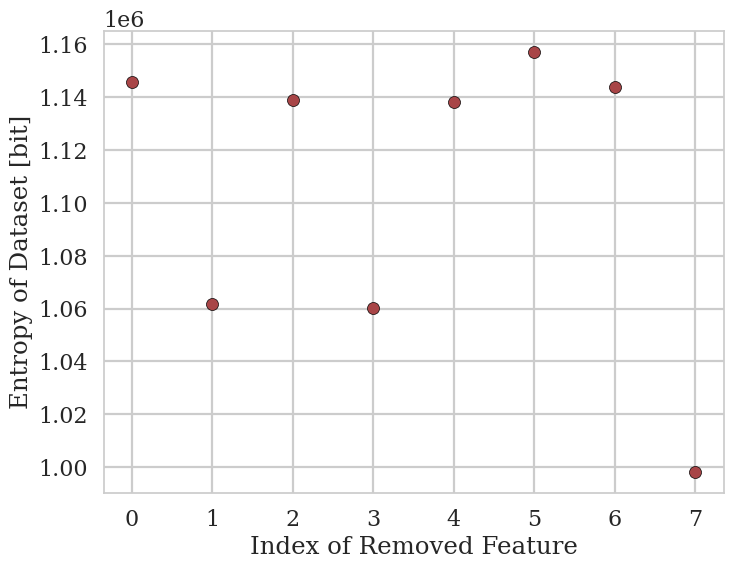

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(features_ranked_entropy.index, features_ranked_entropy.values,
            c="#A84547", s=75, edgecolors='black'
           )
plt.xlabel("Index of Removed Feature")
plt.ylabel("Entropy of Dataset [bit]");

plt.savefig(fig_path+"entropy_all_variables.pdf", format="pdf", dpi=800, bbox_inches='tight');

In [10]:
print(ordered_features,)

['RHOSTAR', 'BETASTAR', 'TAV', 'NUSTAR', 'QCYL5', 'ENBI', 'PLTH', 'TOK']


## The following plot helps to se how much cleaning was affecting the maing variables

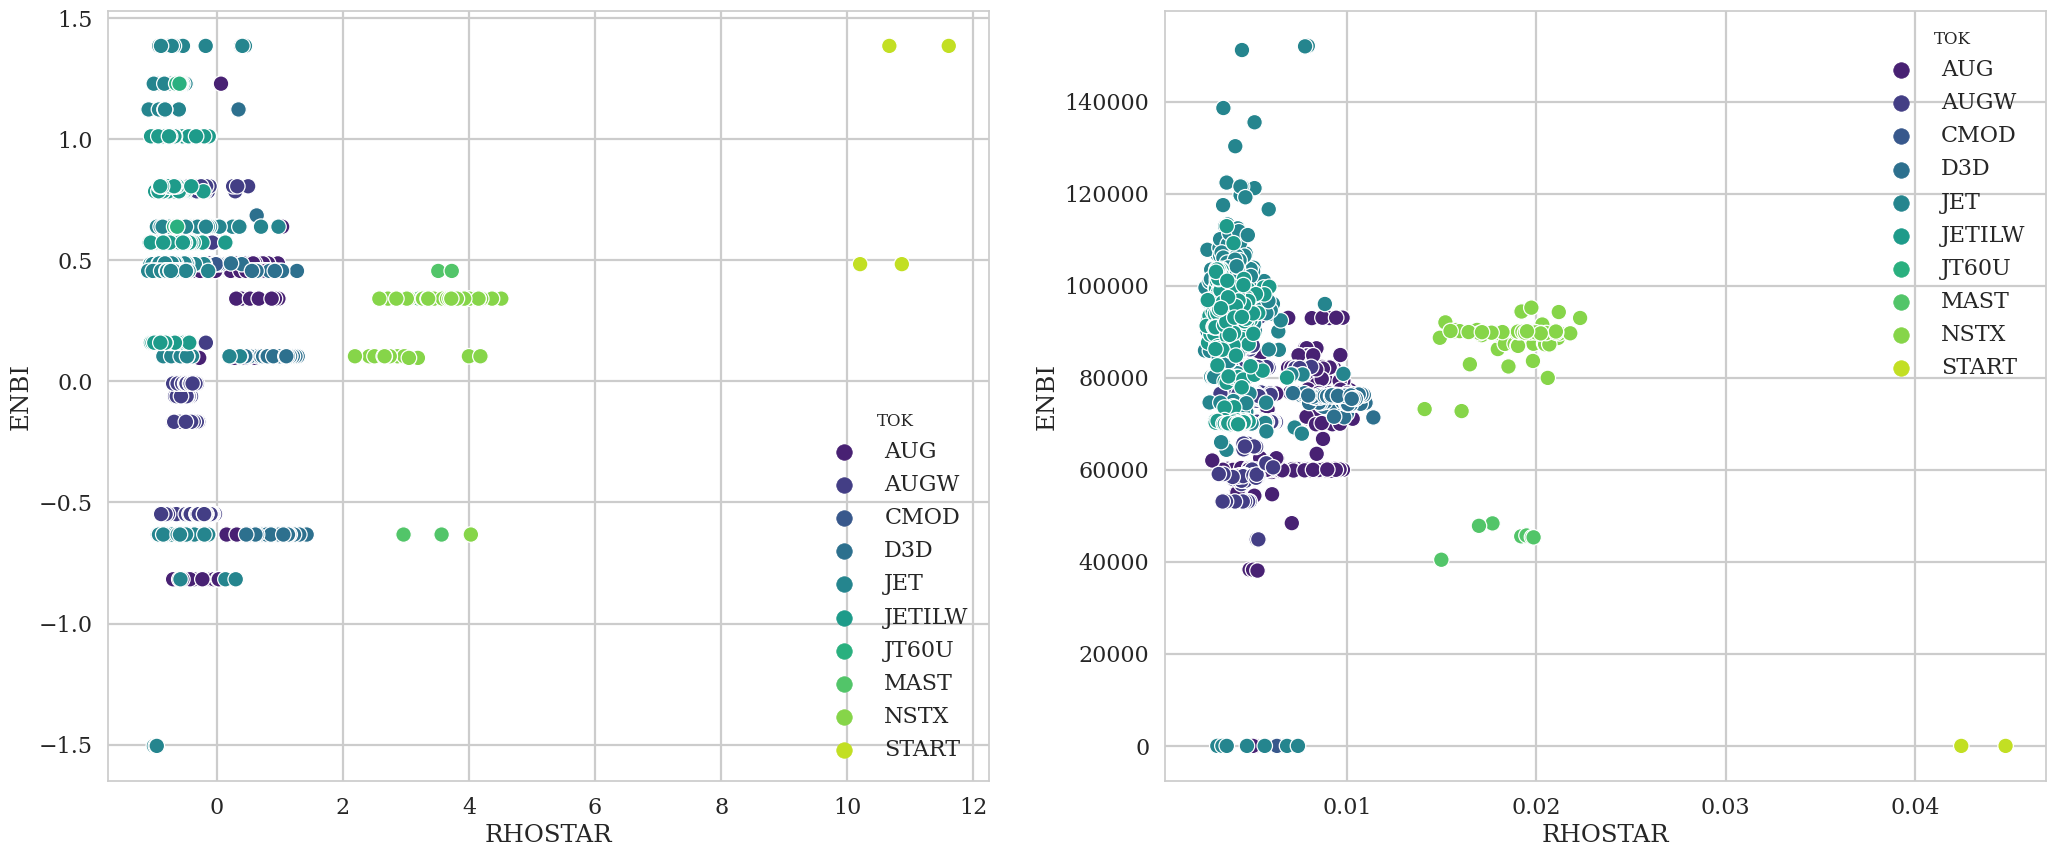

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(25,10))
fig.subplots_adjust(hspace=0.4)

sns.scatterplot(data=data, x="RHOSTAR", y="ENBI", hue="TOK", palette="viridis", ax=axs[0])
sns.scatterplot(data=DB5[DB5.label.isin([1])], x="RHOSTAR", y="ENBI", hue="TOK", palette="viridis", ax=axs[1]);

In [25]:
data["ENBI"].isna().unique()

array([False])

In [26]:
DB5[DB5.label.isin([1])][features]["ENBI"].isna().sum()

14

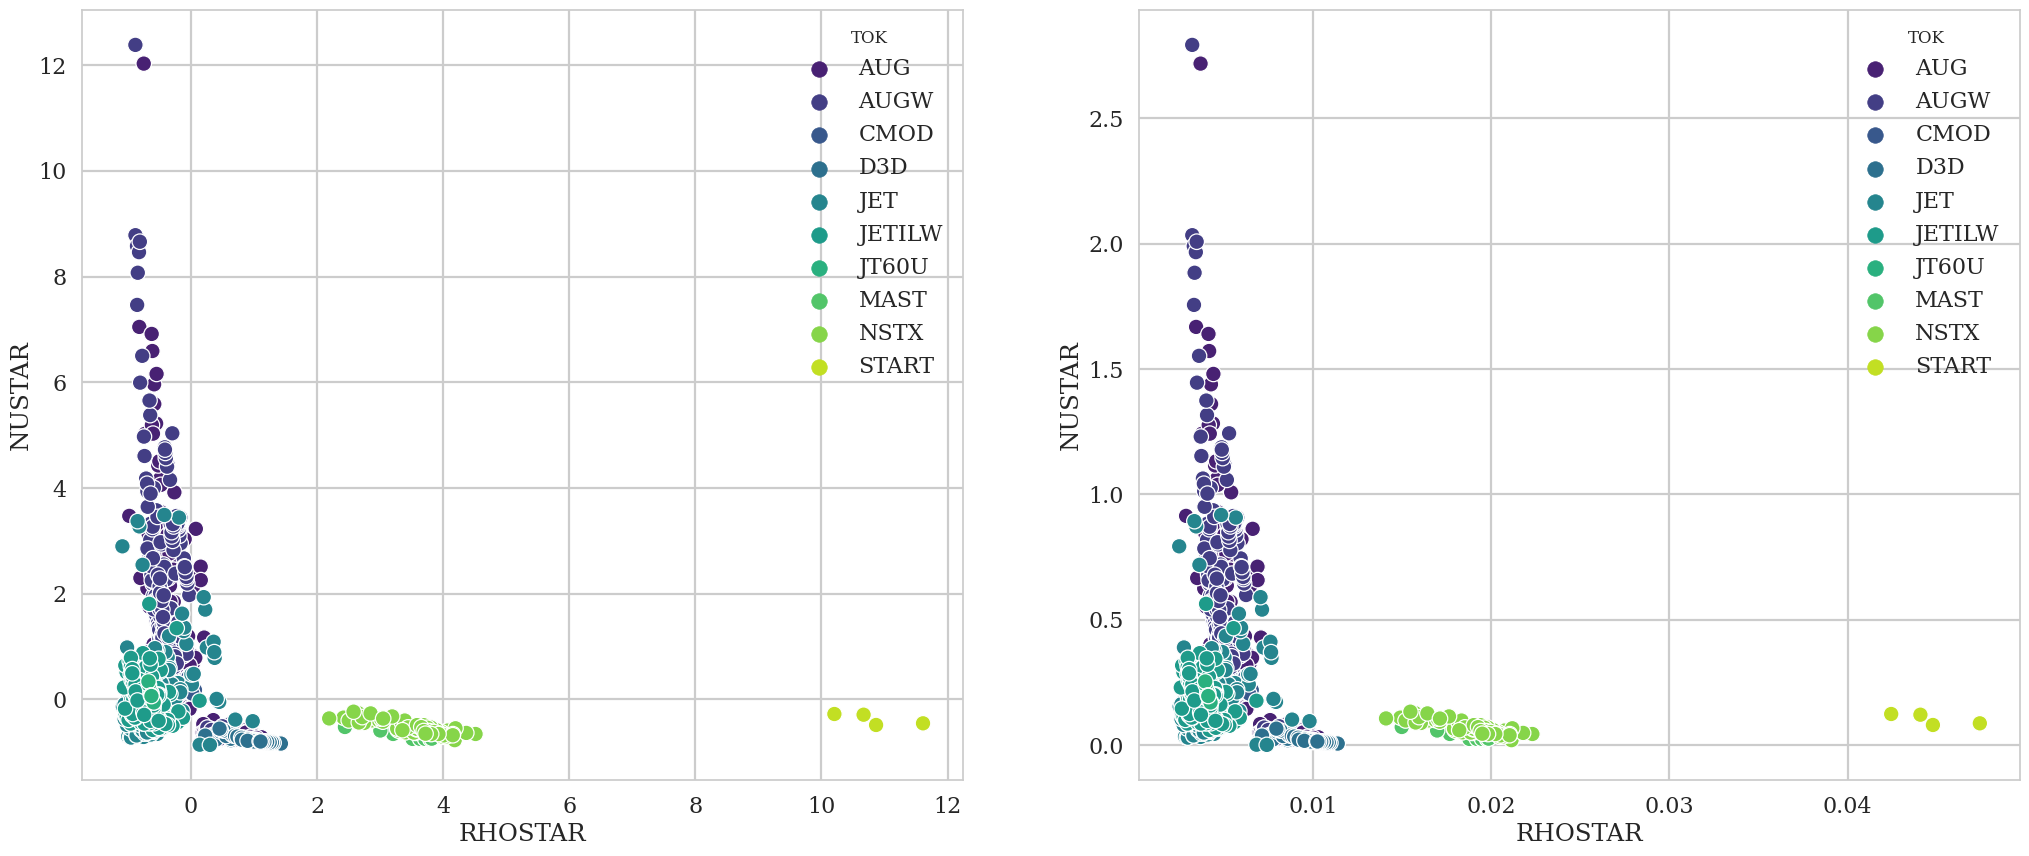

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(25,10))
fig.subplots_adjust(hspace=0.4)

sns.scatterplot(data=data, x="RHOSTAR", y="NUSTAR", hue="TOK", palette="viridis", ax=axs[0])
sns.scatterplot(data=DB5[DB5.label.isin([1])], x="RHOSTAR", y="NUSTAR", hue="TOK", palette="viridis", ax=axs[1]);

## Comparison between decreasing and increasing dataset

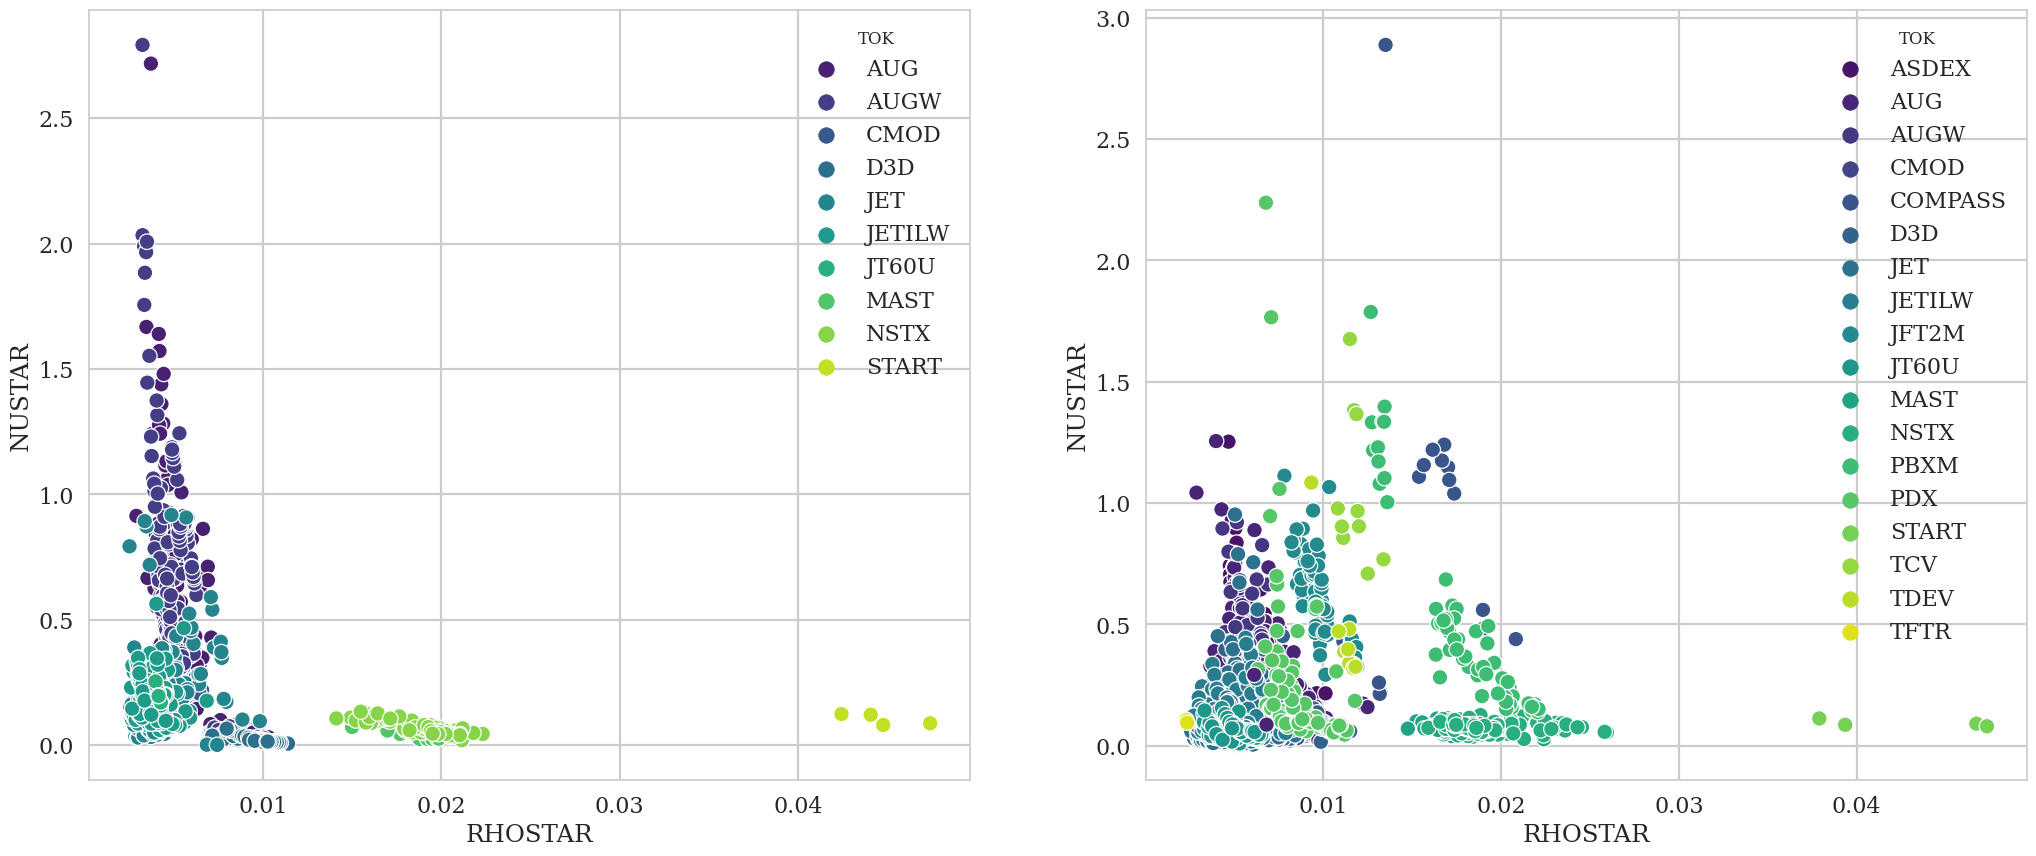

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(25,10))
fig.subplots_adjust(hspace=0.4)

sns.scatterplot(data=DB5[DB5.label.isin([1])], x="RHOSTAR", y="NUSTAR", hue="TOK", palette="viridis", ax=axs[0])
sns.scatterplot(data=DB5[DB5.label.isin([0])], x="RHOSTAR", y="NUSTAR", hue="TOK", palette="viridis", ax=axs[1]);